In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census
from Help.transport_helper_functions import *
from scipy.stats import linregress

from config import api_key
c = Census(api_key, year=2017)

In [2]:
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels

In [3]:
# Load mapping of Chicago zipcode to Chicago city area into DataFrame

# Set location of mapping file
mapping_file = "../Data/zipcode_to_area_map.csv"

# Create DataFrame
df_zip_to_area_map = pd.read_csv(mapping_file)
df_zip_to_area_map = df_zip_to_area_map.astype(str)

df_zip_to_area_map.head()


,Zipcode,Area
0,60601,Central
1,60602,Central
2,60603,Central
3,60604,Central
4,60605,Central


In [4]:
# Load successful restaurant information into a DataFrame

# Set location of mapping file
yelp_file = "../Data/Yelp_Restaurants_Chicago.csv"

# Create DataFrame
df_yelp = pd.read_csv(yelp_file)
df_yelp = df_yelp.astype({'zip': str}) 

# Filter for successful marketing channel campaigns, defined as 4 star rating or better
df_yelp_success = df_yelp.loc[df_yelp['rating'] >= 4, :]

# Add Chicago city area to table to support visualization
df_yelp_success_area = pd.merge(df_yelp_success, df_zip_to_area_map, left_on = 'zip', right_on = 'Zipcode', how = 'left')

# Group by Chicago city area and get count of ratings meeting success criteria
success_grp_zip = df_yelp_success_area.groupby(['zip'])
df_success_group_zip = pd.DataFrame(success_grp_zip['name'].count())
df_success_group_zip = df_success_group_zip.rename(columns = {'name': 'success_count'})

df_success_group_zip.head()

,success_count
zip,
60601,4
60602,9
60603,13
60604,2
60605,24


In [5]:
# Group by Chicago city area and get count of ratings meeting success criteria
success_grp_area = df_yelp_success_area.groupby(['Area'])
df_success_group_area = pd.DataFrame(success_grp_area['name'].count())
df_success_group_area = df_success_group_area.rename(columns = {'name': 'success_count'})

df_success_group_area.head()

,success_count
Area,
Central,258
Far North Side,265
Far South East Side,24
Far South West Side,19
North Side,241


In [6]:
# Create zipcode table to filter Census data to only Chicago zipcodes 

# Create series of Chicago zipcodes
chi_zip = ['60666','60686']

chi_seq = 60601

for i in range(56):
    chi_zip.append(str(chi_seq))
    
    # skip invalid zipcodes
    if chi_seq in ([60626, 60634, 60647, 60649, 60657]):
        chi_seq += 1
        
    chi_seq += 1
    i += 1

# Create Chicago zipcode DataFrame
df_chi_zip = pd.DataFrame(data=chi_zip)
df_chi_zip.rename(columns = {0:"Zipcode"}, inplace=True)

df_chi_zip.head()

,Zipcode
0,60666
1,60686
2,60601
3,60602
4,60603


In [7]:
# Run Census Search to retrieve general data on all zip codes (2017 ACS5 Census)
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E", 
                          "B19301_001E", "B17001_002E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_general = pd.DataFrame(census_data)

# Column Reordering
df_census_general = df_census_general.rename(columns={"B01003_001E": "Population",
                                                      "B01002_001E": "Median Age",
                                                      "B19013_001E": "Median Household Income",
                                                      "B19301_001E": "Per Capita Income",
                                                      "B17001_002E": "Poverty Count",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
df_census_general["Poverty Rate"] = 100 * \
    df_census_general["Poverty Count"].astype(
        int) / df_census_general["Population"].astype(int)

# Final DataFrame
df_census_general = df_census_general[["Zipcode", "Population", "Median Age", "Median Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate"]]

# Visualize
print(len(df_census_general))
df_census_general.head()

33120


,Zipcode,Population,Median Age,Median Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,00601,17599.0,38.9,11757.0,7041.0,11282.0,64.105915
1,00602,39209.0,40.9,16190.0,8978.0,20428.0,52.100283
2,00603,50135.0,40.4,16645.0,10897.0,25176.0,50.216416
3,00606,6304.0,42.8,13387.0,5960.0,4092.0,64.911168
4,00610,27590.0,41.4,18741.0,9266.0,12553.0,45.498369


In [8]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant general data set
# and drop n/a zipcodes with no statistics
df_chi_general = pd.merge(df_census_general, df_chi_zip, on='Zipcode', how = 'right')
df_chi_general = df_chi_general.dropna(how="any")

print(len(df_chi_general))
df_chi_general.head()

56


,Zipcode,Population,Median Age,Median Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,60601,13887.0,37.6,110215.0,95152.0,1171.0,8.432347
1,60602,1277.0,31.1,115774.0,77279.0,32.0,2.505873
2,60603,1197.0,26.7,140114.0,106207.0,261.0,21.804511
3,60604,668.0,40.6,114565.0,130966.0,127.0,19.011976
4,60605,26188.0,33.6,107811.0,81144.0,2312.0,8.828471


In [9]:
# add city area to general information based on zipcode
df_chi_general_area = pd.merge(df_chi_general, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left')

print(len(df_chi_general_area))
df_chi_general_area.head()

56


,Zipcode,Population,Median Age,Median Household Income,Per Capita Income,Poverty Count,Poverty Rate,Area
0,60601,13887.0,37.6,110215.0,95152.0,1171.0,8.432347,Central
1,60602,1277.0,31.1,115774.0,77279.0,32.0,2.505873,Central
2,60603,1197.0,26.7,140114.0,106207.0,261.0,21.804511,Central
3,60604,668.0,40.6,114565.0,130966.0,127.0,19.011976,Central
4,60605,26188.0,33.6,107811.0,81144.0,2312.0,8.828471,Central


In [10]:
# add success counts to general data based on zipcode
df_chi_general_area = pd.merge(df_chi_general_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

# correct count for 60636 that has no yelp ratings
df_chi_general_area.loc[df_chi_general_area['Zipcode']=='60636', ['success_count']] = 0

print(len(df_chi_general_area))
df_chi_general_area.head()

56


,Zipcode,Population,Median Age,Median Household Income,Per Capita Income,Poverty Count,Poverty Rate,Area,success_count
0,60601,13887.0,37.6,110215.0,95152.0,1171.0,8.432347,Central,4.0
1,60602,1277.0,31.1,115774.0,77279.0,32.0,2.505873,Central,9.0
2,60603,1197.0,26.7,140114.0,106207.0,261.0,21.804511,Central,13.0
3,60604,668.0,40.6,114565.0,130966.0,127.0,19.011976,Central,2.0
4,60605,26188.0,33.6,107811.0,81144.0,2312.0,8.828471,Central,24.0


In [11]:
# Save general data as a csv
df_chi_general_area.to_csv("../Data/census_general.csv", encoding="utf-8", index=False)

In [12]:
# Run the t-test
(t_stat, p) = stats.ttest_ind(df_chi_general_area['success_count'], df_chi_general_area['Median Age'], equal_var=False)
print(f"{t_stat}")

-6.183705234462478


LinregressResult(slope=-0.054773157019866583, intercept=36.00696816992075, rvalue=-0.2689911930056542, pvalue=0.04499937583371065, stderr=0.026688455497053273)


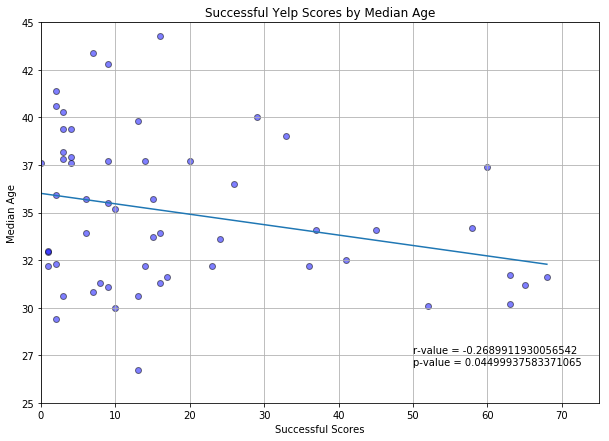

In [13]:
#**********************************************************
# Build the scatter plot for success counts against % highest level of education attained (data by zipcode)
fig1, ax = plt.subplots()
        
#fig = plt.figure()
ax1 = plt.scatter(df_chi_general_area['success_count'],df_chi_general_area['Median Age'], marker="o", facecolors='b', edgecolors="black", linewidths = 1, alpha=0.50)

# Get correlation statistics by highest education level attained
tl = gen_linear_trend(list(df_chi_general_area['success_count']), list(df_chi_general_area['Median Age']))

# Get regression stats and add to plot
l1=linregress(df_chi_general_area['success_count'], df_chi_general_area['Median Age'])
rvalue = l1[2]
pvalue = l1[3]  
stat_label = ("r-value = " + str(rvalue) + "\np-value = " + str(pvalue)) 
plt.text(50,27,stat_label,multialignment = 'left')

# Incorporate the other graph properties
plt.xlabel("Successful Scores")
plt.ylabel("Median Age")
plt.ylim(25,45)
plt.xlim(0,75)

# Set legend parameters
plt.grid()
#lgnd = plt.legend((ax1), ('Less than HS', ))
#lgnd.legendHandles[0]._sizes = [50]
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:0}".format(int(x))))
ax.set_title("Successful Yelp Scores by Median Age")
fig1.set_size_inches(10,7)

# Add best fit line
plt.plot(np.unique(df_chi_general_area['success_count']), np.poly1d(np.polyfit(df_chi_general_area['success_count'],df_chi_general_area['Median Age'],1))(np.unique(df_chi_general_area['success_count'])))

# Save Figure
plt.savefig("../Chart/Median_Age_by_Success_Score_scatter.png")

# Show plot
plt.show()


LinregressResult(slope=466.1345239798903, intercept=54968.852994300236, rvalue=0.2935922978061978, pvalue=0.028082096338968496, stderr=206.5361872376122)


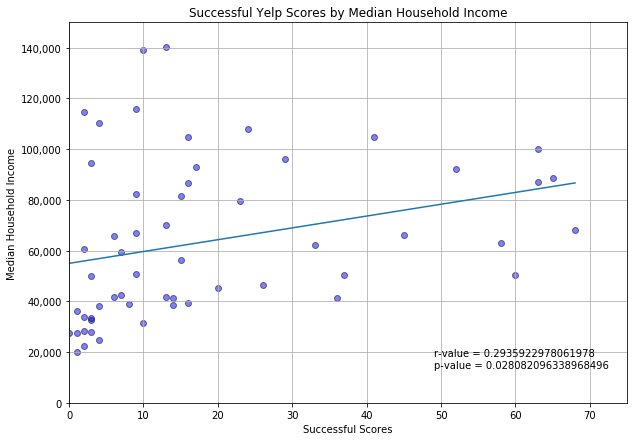

In [68]:
# **********************************************************
# Build the scatter plot for success counts against % highest level of education attained (data by zipcode)
fig1, ax = plt.subplots()
        
#fig = plt.figure()
ax1 = plt.scatter(df_chi_general_area['success_count'],df_chi_general_area['Median Household Income'], marker="o", facecolors='b', edgecolors="black", linewidths = 1, alpha=0.50)

# Get regression stats and add to plot
l1=linregress(df_chi_general_area['success_count'], df_chi_general_area['Median Household Income'])
rvalue = l1[2]
pvalue = l1[3]  
stat_label = ("r-value = " + str(rvalue) + "\np-value = " + str(pvalue) + "\n\n\n") 
plt.text(49,20,stat_label,multialignment = 'left')

# Incorporate the other graph properties
plt.xlabel("Successful Scores")
plt.ylabel("Median Household Income")
plt.ylim(0,150000)
plt.xlim(0,75)

# Set legend parameters
plt.grid()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_title("Successful Yelp Scores by Median Household Income")
fig1.set_size_inches(10,7)

# Add best fit line
plt.plot(np.unique(df_chi_general_area['success_count']), np.poly1d(np.polyfit(df_chi_general_area['success_count'],df_chi_general_area['Median Household Income'],1))(np.unique(df_chi_general_area['success_count'])))

# Get correlation statistics by highest education level attained
tl = gen_linear_trend( list(df_chi_general_area['success_count']), list(df_chi_general_area['Median Household Income']))

# Save Figure
plt.savefig("../Chart/Median_Household Income_by_Success_Scor_scatter.png")

# Show plot
plt.show()


In [15]:
# Run Census Search to retrieve race data on all zip codes (2017 ACS5 Census)
census_data = c.acs5.get(("NAME", "B02001_001E", "B02001_002E", "B02001_003E", "B02001_004E",
                          "B02001_005E", "B02001_006E", "B02001_007E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_race = pd.DataFrame(census_data)

# Column Reordering
df_census_race = df_census_race.rename(columns={"B02001_001E": "Total",
                                                "B02001_002E": "White", 
                                                "B02001_003E": "Black",
                                                "B02001_004E": "Native American",
                                                "B02001_005E": "Asian",
                                                "B02001_006E": "Pacific Islander",
                                                "B02001_007E": "Other",
                                                  "NAME": "Name", "zip code tabulation area": "Zipcode"})
# Final DataFrame
df_census_race = df_census_race[["Zipcode", "Total", "White", "Black", "Native American", "Asian", 
                                    "Pacific Islander", "Other"]]

# Visualize
print(len(df_census_race))
df_census_race.head()

33120


,Zipcode,Total,White,Black,Native American,Asian,Pacific Islander,Other
0,84306,345.0,345.0,0.0,0.0,0.0,0.0,0.0
1,84775,421.0,419.0,0.0,0.0,0.0,0.0,0.0
2,84762,211.0,211.0,0.0,0.0,0.0,0.0,0.0
3,84772,203.0,203.0,0.0,0.0,0.0,0.0,0.0
4,84781,224.0,224.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant race data set
# and drop n/a zipcodes with no statistics
df_chi_race = pd.merge(df_census_race, df_chi_zip, on='Zipcode', how = 'right')
df_chi_race = df_chi_race.dropna(how="any")

print(len(df_chi_race))
df_chi_race.head()

56


,Zipcode,Total,White,Black,Native American,Asian,Pacific Islander,Other
0,60607,28928.0,17396.0,3681.0,30.0,6399.0,26.0,377.0
1,60609,60994.0,29002.0,14628.0,402.0,3755.0,12.0,11885.0
2,60625,80676.0,53120.0,3981.0,112.0,11272.0,41.0,8098.0
3,60646,27865.0,23611.0,246.0,6.0,2713.0,0.0,745.0
4,60652,43582.0,11459.0,20510.0,133.0,325.0,12.0,9717.0


In [17]:
# add city area to race information based on zipcode
df_chi_race_area = pd.merge(df_chi_race, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_race_area))
df_chi_race_area.head()

56


,Zipcode,Total,White,Black,Native American,Asian,Pacific Islander,Other,Area
0,60607,28928.0,17396.0,3681.0,30.0,6399.0,26.0,377.0,Central
1,60609,60994.0,29002.0,14628.0,402.0,3755.0,12.0,11885.0,South Side
2,60625,80676.0,53120.0,3981.0,112.0,11272.0,41.0,8098.0,Far North Side
3,60646,27865.0,23611.0,246.0,6.0,2713.0,0.0,745.0,Far North Side
4,60652,43582.0,11459.0,20510.0,133.0,325.0,12.0,9717.0,Far South West Side


In [18]:
# add success counts to race data based on zipcode
df_chi_race_area = pd.merge(df_chi_race_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

# correct count for 60636 that has no yelp ratings
df_chi_race_area.loc[df_chi_race_area['Zipcode']=='60636', ['success_count']] = 0

print(len(df_chi_race_area))
df_chi_race_area.head()

56


,Zipcode,Total,White,Black,Native American,Asian,Pacific Islander,Other,Area,success_count
0,60607,28928.0,17396.0,3681.0,30.0,6399.0,26.0,377.0,Central,52.0
1,60609,60994.0,29002.0,14628.0,402.0,3755.0,12.0,11885.0,South Side,2.0
2,60625,80676.0,53120.0,3981.0,112.0,11272.0,41.0,8098.0,Far North Side,58.0
3,60646,27865.0,23611.0,246.0,6.0,2713.0,0.0,745.0,Far North Side,16.0
4,60652,43582.0,11459.0,20510.0,133.0,325.0,12.0,9717.0,Far South West Side,6.0


In [19]:
# Save race data as a csv
df_chi_race_area.to_csv("../Data/census_race.csv", encoding="utf-8", index=False)

In [20]:
# Run Census Search to retrieve education level data on all zip codes (2017 ACS5 Census)
census_data = c.acs5.get(("NAME", "B06009_001E", "B06009_002E", "B06009_003E", 
                          "B06009_004E", "B06009_005E", "B06009_006E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_education_level = pd.DataFrame(census_data)

# Column Reordering
df_census_education_level = df_census_education_level.rename(columns={"B06009_001E": "Total",
                                                      "B06009_002E": "Less_than_HS",
                                                      "B06009_003E": "High_School",
                                                      "B06009_004E": "Some_College",
                                                      "B06009_005E": "Bachelor_Degree",
                                                      "B06009_006E": "Grad_Degree",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
df_census_education_level = df_census_education_level[["Zipcode", "Total", "Less_than_HS", "High_School",
                       "Some_College", "Bachelor_Degree", "Grad_Degree"]]

# Visualize
print(len(df_census_education_level))
df_census_education_level.head()

33120


,Zipcode,Total,Less_than_HS,High_School,Some_College,Bachelor_Degree,Grad_Degree
0,84306,204.0,0.0,41.0,110.0,35.0,18.0
1,84775,343.0,61.0,52.0,76.0,71.0,83.0
2,84762,168.0,0.0,93.0,31.0,22.0,22.0
3,84772,142.0,26.0,61.0,41.0,6.0,8.0
4,84781,126.0,0.0,23.0,15.0,88.0,0.0


In [21]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant education level data set
# and drop n/a zipcodes with no statistics
df_chi_education_level = pd.merge(df_census_education_level, df_chi_zip, on='Zipcode', how = 'right')
df_chi_education_level = df_chi_education_level.dropna(how="any")

print(len(df_chi_education_level))
df_chi_education_level.head()

56


,Zipcode,Total,Less_than_HS,High_School,Some_College,Bachelor_Degree,Grad_Degree
0,60607,19377.0,903.0,1359.0,1938.0,7661.0,7516.0
1,60609,37530.0,10055.0,15022.0,7556.0,3161.0,1736.0
2,60625,57018.0,8863.0,10062.0,10686.0,17244.0,10163.0
3,60646,20025.0,1382.0,3722.0,4255.0,6499.0,4167.0
4,60652,27213.0,4168.0,8216.0,9108.0,3710.0,2011.0


In [22]:
# add city area to education level information based on zipcode
df_chi_education_level_area = pd.merge(df_chi_education_level, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_education_level_area))
df_chi_education_level_area.head()

56


,Zipcode,Total,Less_than_HS,High_School,Some_College,Bachelor_Degree,Grad_Degree,Area
0,60607,19377.0,903.0,1359.0,1938.0,7661.0,7516.0,Central
1,60609,37530.0,10055.0,15022.0,7556.0,3161.0,1736.0,South Side
2,60625,57018.0,8863.0,10062.0,10686.0,17244.0,10163.0,Far North Side
3,60646,20025.0,1382.0,3722.0,4255.0,6499.0,4167.0,Far North Side
4,60652,27213.0,4168.0,8216.0,9108.0,3710.0,2011.0,Far South West Side


In [23]:
# add success counts to education level data based on zipcode
df_chi_education_level_area = pd.merge(df_chi_education_level_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

# correct count for 60636 that has no yelp ratings
df_chi_education_level_area.loc[df_chi_education_level_area['Zipcode']=='60636', ['success_count']] = 0

print(len(df_chi_education_level_area))
df_chi_education_level_area.head()

56


,Zipcode,Total,Less_than_HS,High_School,Some_College,Bachelor_Degree,Grad_Degree,Area,success_count
0,60607,19377.0,903.0,1359.0,1938.0,7661.0,7516.0,Central,52.0
1,60609,37530.0,10055.0,15022.0,7556.0,3161.0,1736.0,South Side,2.0
2,60625,57018.0,8863.0,10062.0,10686.0,17244.0,10163.0,Far North Side,58.0
3,60646,20025.0,1382.0,3722.0,4255.0,6499.0,4167.0,Far North Side,16.0
4,60652,27213.0,4168.0,8216.0,9108.0,3710.0,2011.0,Far South West Side,6.0


In [24]:
df_chi_education_level_area.head()

,Zipcode,Total,Less_than_HS,High_School,Some_College,Bachelor_Degree,Grad_Degree,Area,success_count
0,60607,19377.0,903.0,1359.0,1938.0,7661.0,7516.0,Central,52.0
1,60609,37530.0,10055.0,15022.0,7556.0,3161.0,1736.0,South Side,2.0
2,60625,57018.0,8863.0,10062.0,10686.0,17244.0,10163.0,Far North Side,58.0
3,60646,20025.0,1382.0,3722.0,4255.0,6499.0,4167.0,Far North Side,16.0
4,60652,27213.0,4168.0,8216.0,9108.0,3710.0,2011.0,Far South West Side,6.0


In [25]:
# Calculate percent of zipcode population by highest education level attained
df_chi_education_level_area['Less_than_HS_P'] = round(df_chi_education_level_area['Less_than_HS']/df_chi_education_level_area['Total'] *100,1)
df_chi_education_level_area['High_School_P'] = round(df_chi_education_level_area['High_School']/df_chi_education_level_area['Total'] *100,1)
df_chi_education_level_area['Some_College_P'] = round(df_chi_education_level_area['Some_College']/df_chi_education_level_area['Total'] *100,1)
df_chi_education_level_area['Bachelor_Degree_P'] = round(df_chi_education_level_area['Bachelor_Degree']/df_chi_education_level_area['Total'] *100,1)
df_chi_education_level_area['Grad_Degree_P'] = round(df_chi_education_level_area['Grad_Degree']/df_chi_education_level_area['Total'] *100,1)

df_chi_education_level_area.head()

,Zipcode,Total,Less_than_HS,High_School,Some_College,Bachelor_Degree,Grad_Degree,Area,success_count,Less_than_HS_P,High_School_P,Some_College_P,Bachelor_Degree_P,Grad_Degree_P
0,60607,19377.0,903.0,1359.0,1938.0,7661.0,7516.0,Central,52.0,4.7,7.0,10.0,39.5,38.8
1,60609,37530.0,10055.0,15022.0,7556.0,3161.0,1736.0,South Side,2.0,26.8,40.0,20.1,8.4,4.6
2,60625,57018.0,8863.0,10062.0,10686.0,17244.0,10163.0,Far North Side,58.0,15.5,17.6,18.7,30.2,17.8
3,60646,20025.0,1382.0,3722.0,4255.0,6499.0,4167.0,Far North Side,16.0,6.9,18.6,21.2,32.5,20.8
4,60652,27213.0,4168.0,8216.0,9108.0,3710.0,2011.0,Far South West Side,6.0,15.3,30.2,33.5,13.6,7.4


In [26]:
# Save education level data as a csv
df_chi_education_level_area.to_csv("../Data/census_education_level.csv", encoding="utf-8", index=False)

LinregressResult(slope=-0.11406132639866816, intercept=15.4348834432611, rvalue=-0.21629660288408262, pvalue=0.10934894542054804, stderr=0.07006279373328476)
LinregressResult(slope=-0.2549120309722785, intercept=25.280963429576936, rvalue=-0.4242027777747777, pvalue=0.001121233337103291, stderr=0.07405265641740418)
LinregressResult(slope=-0.23329943341120993, intercept=26.697587742510752, rvalue=-0.49357068830891626, pvalue=0.00011091760653702636, stderr=0.055942227097113946)
LinregressResult(slope=0.3852814780253138, intercept=17.538101254353574, rvalue=0.5406022967656288, pvalue=1.7000371166204752e-05, stderr=0.08159114826923003)
LinregressResult(slope=0.21701028090644048, intercept=15.048113558247039, rvalue=0.2874358749149298, pvalue=0.03171258525971645, stderr=0.09840501633854973)


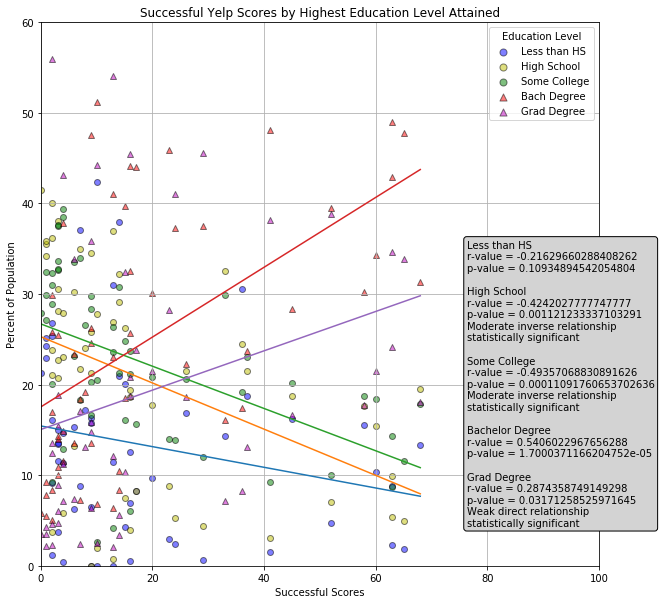

In [163]:
#**********************************************************
# Build the scatter plot for success counts against % highest level of education attained (data by zipcode)
fig1, ax = plt.subplots()

#fig = plt.figure()
ax1 = plt.scatter(df_chi_education_level_area['success_count'],df_chi_education_level_area['Less_than_HS_P'], marker="o", facecolors='b', edgecolors="black", linewidths = 1, alpha=0.50)
ax2 = plt.scatter(df_chi_education_level_area['success_count'],df_chi_education_level_area['High_School_P'], marker="o", facecolors='y', edgecolors="black", linewidths = 1, alpha=0.50)
ax3 = plt.scatter(df_chi_education_level_area['success_count'],df_chi_education_level_area['Some_College_P'], marker="o", facecolors='g', edgecolors="black", linewidths = 1, alpha = 0.50)
ax4 = plt.scatter(df_chi_education_level_area['success_count'],df_chi_education_level_area['Bachelor_Degree_P'], marker="^", facecolors='r', edgecolors="black", linewidths = 1, alpha = 0.50)
ax5 = plt.scatter(df_chi_education_level_area['success_count'],df_chi_education_level_area['Grad_Degree_P'], marker="^", facecolors='m', edgecolors="black", linewidths = 1, alpha = 0.50)

# Incorporate the other graph properties
plt.xlabel("Successful Scores")
plt.ylabel("Percent of Population")
plt.ylim(0,60)
plt.xlim(0,100)

# Get regression stats and add to plot
l1=linregress(df_chi_education_level_area['success_count'], df_chi_education_level_area['Less_than_HS_P'])
rvalue1 = l1[2]
pvalue1 = l1[3]  

l2=linregress(df_chi_education_level_area['success_count'], df_chi_education_level_area['High_School_P'])
rvalue2 = l2[2]
pvalue2 = l2[3]  

l3=linregress(df_chi_education_level_area['success_count'], df_chi_education_level_area['Some_College_P'])
rvalue3 = l3[2]
pvalue3 = l3[3]  

l4=linregress(df_chi_education_level_area['success_count'], df_chi_education_level_area['Bachelor_Degree_P'])
rvalue4 = l4[2]
pvalue4 = l4[3]  

l5=linregress(df_chi_education_level_area['success_count'], df_chi_education_level_area['Grad_Degree_P'])
rvalue5 = l5[2]
pvalue5 = l5[3]  

stat_label = ("Less than HS\nr-value = " + str(rvalue1) + "\np-value = " + str(pvalue1) + "\n\nHigh School\nr-value = " + str(rvalue2) + "\np-value = " + str(pvalue2) + "\nModerate inverse relationship\nstatistically significant\n\nSome College\nr-value = " + str(rvalue3) + "\np-value = " + str(pvalue3) + "\nModerate inverse relationship\nstatistically significant\n\nBachelor Degree\nr-value = " + str(rvalue4) + "\np-value = " + str(pvalue4) + "\n\nGrad Degree\nr-value = " + str(rvalue5) + "\np-value = " + str(pvalue5) + "\nWeak direct relationship\nstatistically significant") 

props = dict(boxstyle='round',facecolor = 'lightgrey', alpha=1)
ax.text(1.1, .60, stat_label, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', multialignment = 'left', bbox=props)

# Set legend parameters
plt.grid()
lgnd = plt.legend((ax1, ax2, ax3, ax4, ax5), ('Less than HS', 'High School', 'Some College','Bach Degree','Grad Degree'), title = 'Education Level')
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]
lgnd.legendHandles[4]._sizes = [50]

ax.set_title("Successful Yelp Scores by Highest Education Level Attained")
fig1.set_size_inches(10,10)

# Add best fit line
plt.plot(np.unique(df_chi_education_level_area['success_count']), np.poly1d(np.polyfit(df_chi_education_level_area['success_count'],df_chi_education_level_area['Less_than_HS_P'],1))(np.unique(df_chi_education_level_area['success_count'])))
plt.plot(np.unique(df_chi_education_level_area['success_count']), np.poly1d(np.polyfit(df_chi_education_level_area['success_count'],df_chi_education_level_area['High_School_P'],1))(np.unique(df_chi_education_level_area['success_count'])))
plt.plot(np.unique(df_chi_education_level_area['success_count']), np.poly1d(np.polyfit(df_chi_education_level_area['success_count'],df_chi_education_level_area['Some_College_P'],1))(np.unique(df_chi_education_level_area['success_count'])))
plt.plot(np.unique(df_chi_education_level_area['success_count']), np.poly1d(np.polyfit(df_chi_education_level_area['success_count'],df_chi_education_level_area['Bachelor_Degree_P'],1))(np.unique(df_chi_education_level_area['success_count'])))
plt.plot(np.unique(df_chi_education_level_area['success_count']), np.poly1d(np.polyfit(df_chi_education_level_area['success_count'],df_chi_education_level_area['Grad_Degree_P'],1))(np.unique(df_chi_education_level_area['success_count'])))
 
# Get correlation statistics by highest education level attained
tl = gen_linear_trend( list(df_chi_education_level_area['success_count']), list(df_chi_education_level_area['Less_than_HS_P']))
t2 = gen_linear_trend( list(df_chi_education_level_area['success_count']), list(df_chi_education_level_area['High_School_P']))
t3 = gen_linear_trend( list(df_chi_education_level_area['success_count']), list(df_chi_education_level_area['Some_College_P']))
t4 = gen_linear_trend( list(df_chi_education_level_area['success_count']), list(df_chi_education_level_area['Bachelor_Degree_P']))
t5 = gen_linear_trend( list(df_chi_education_level_area['success_count']), list(df_chi_education_level_area['Grad_Degree_P']))

# Save Figure
plt.savefig("../Chart/Education_Level_by_Success_Scor_scatter.png")

# Show plot
plt.show()

In [113]:
# Run Census Search to retrieve household size data on all zip codes (2017 ACS5 Census)

census_data = c.acs5.get(("NAME", "B08201_007E", "B08201_013E", "B08201_019E", 
                          "B08201_025E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_household_size = pd.DataFrame(census_data)

# Column Reordering
df_census_household_size = df_census_household_size.rename(columns={"B08201_007E": "1 Person",
                                                      "B08201_013E": "2 People",
                                                      "B08201_019E": "3 People",
                                                      "B08201_025E": "4 or More People",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
df_census_household_size = df_census_household_size[["Zipcode", "1 Person", "2 People", "3 People", "4 or More People"]]

# Visualize
print(len(df_census_household_size))
df_census_household_size.head()

33120


,Zipcode,1 Person,2 People,3 People,4 or More People
0,84306,13.0,37.0,54.0,28.0
1,84775,65.0,87.0,21.0,14.0
2,84762,10.0,22.0,0.0,31.0
3,84772,39.0,14.0,27.0,9.0
4,84781,22.0,17.0,0.0,35.0


In [30]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant education level data set
# and drop n/a zipcodes with no statistics
df_chi_household_size = pd.merge(df_census_household_size, df_chi_zip, on='Zipcode', how = 'right')
df_chi_household_size = df_chi_household_size.dropna(how="any")

# add household total for later percentage calculations
df_chi_household_size['Total'] = (df_chi_household_size['1 Person'] + df_chi_household_size['2 People'] + df_chi_household_size['3 People'] + df_chi_household_size['4 or More People'])

print(len(df_chi_household_size))
df_chi_household_size.head()

56


,Zipcode,1 Person,2 People,3 People,4 or More People,Total
0,60607,5435.0,4636.0,1461.0,1131.0,12663.0
1,60609,5610.0,4756.0,3504.0,6090.0,19960.0
2,60625,8773.0,8862.0,5085.0,6725.0,29445.0
3,60646,3298.0,3325.0,1469.0,2667.0,10759.0
4,60652,2675.0,3305.0,2518.0,4713.0,13211.0


In [31]:
# add city area to household size information based on zipcode
df_chi_household_size_area = pd.merge(df_chi_household_size, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_household_size_area))
df_chi_household_size_area.head()

56


,Zipcode,1 Person,2 People,3 People,4 or More People,Total,Area
0,60607,5435.0,4636.0,1461.0,1131.0,12663.0,Central
1,60609,5610.0,4756.0,3504.0,6090.0,19960.0,South Side
2,60625,8773.0,8862.0,5085.0,6725.0,29445.0,Far North Side
3,60646,3298.0,3325.0,1469.0,2667.0,10759.0,Far North Side
4,60652,2675.0,3305.0,2518.0,4713.0,13211.0,Far South West Side


In [32]:
# add success counts to household size data based on zipcode
df_chi_household_size_area = pd.merge(df_chi_household_size_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

# correct count for 60636 that has no yelp ratings
df_chi_household_size_area.loc[df_chi_household_size_area['Zipcode']=='60636', ['success_count']] = 0

print(len(df_chi_household_size_area))
df_chi_household_size_area.head()

56


,Zipcode,1 Person,2 People,3 People,4 or More People,Total,Area,success_count
0,60607,5435.0,4636.0,1461.0,1131.0,12663.0,Central,52.0
1,60609,5610.0,4756.0,3504.0,6090.0,19960.0,South Side,2.0
2,60625,8773.0,8862.0,5085.0,6725.0,29445.0,Far North Side,58.0
3,60646,3298.0,3325.0,1469.0,2667.0,10759.0,Far North Side,16.0
4,60652,2675.0,3305.0,2518.0,4713.0,13211.0,Far South West Side,6.0


In [33]:
# Calculate percent of zipcode population by household size for visualization
df_chi_household_size_area['1 Person_P'] = round((df_chi_household_size_area['1 Person']/df_chi_household_size_area['Total'])*100,1)
df_chi_household_size_area['2 People_P'] = round((df_chi_household_size_area['2 People']/df_chi_household_size_area['Total'])*100,1)
df_chi_household_size_area['3 People_P'] = round((df_chi_household_size_area['3 People']/df_chi_household_size_area['Total'])*100,1)
df_chi_household_size_area['4 or More People_P'] = round((df_chi_household_size_area['4 or More People']/df_chi_household_size_area['Total'])*100,1)

df_chi_household_size_area.head()

,Zipcode,1 Person,2 People,3 People,4 or More People,Total,Area,success_count,1 Person_P,2 People_P,3 People_P,4 or More People_P
0,60607,5435.0,4636.0,1461.0,1131.0,12663.0,Central,52.0,42.9,36.6,11.5,8.9
1,60609,5610.0,4756.0,3504.0,6090.0,19960.0,South Side,2.0,28.1,23.8,17.6,30.5
2,60625,8773.0,8862.0,5085.0,6725.0,29445.0,Far North Side,58.0,29.8,30.1,17.3,22.8
3,60646,3298.0,3325.0,1469.0,2667.0,10759.0,Far North Side,16.0,30.7,30.9,13.7,24.8
4,60652,2675.0,3305.0,2518.0,4713.0,13211.0,Far South West Side,6.0,20.2,25.0,19.1,35.7


In [34]:
# Save household size data as a csv

df_chi_household_size_area.to_csv("../Data/census_household_size.csv", encoding="utf-8", index=False)

LinregressResult(slope=0.0787520312432521, intercept=36.16592227970061, rvalue=0.12977008591903164, pvalue=0.340465205771184, stderr=0.08188461886090055)
LinregressResult(slope=0.09868747179122837, intercept=28.645686905287125, rvalue=0.2838560549135668, pvalue=0.03399786854039839, stderr=0.045365459041140394)
LinregressResult(slope=-0.023905372643694314, intercept=13.575751083682565, rvalue=-0.10942316228920793, pvalue=0.4220937213978183, stderr=0.02955110253073205)
LinregressResult(slope=-0.15353379167382902, intercept=21.619776328257373, rvalue=-0.25839830336594977, pvalue=0.054497838081944854, stderr=0.07811093872388569)


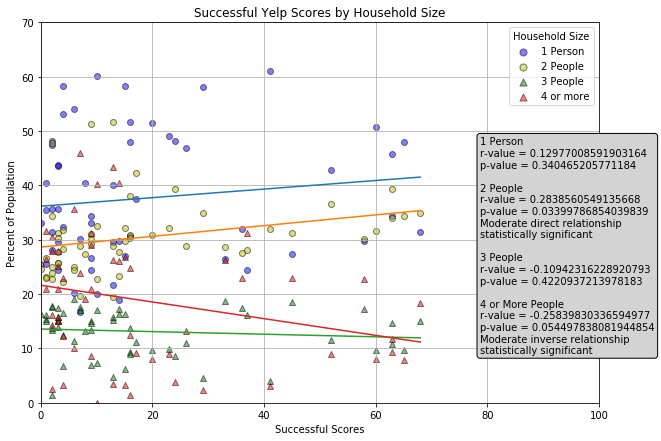

In [174]:
#**********************************************************
# Build the scatter plot for success counts against % household size (data by zipcode)
fig1, ax = plt.subplots()
        
#fig = plt.figure()
ax1 = plt.scatter(df_chi_household_size_area['success_count'],df_chi_household_size_area['1 Person_P'], marker="o", facecolors='b', edgecolors="black", linewidths = 1, alpha=0.50)
ax2 = plt.scatter(df_chi_household_size_area['success_count'],df_chi_household_size_area['2 People_P'], marker="o", facecolors='y', edgecolors="black", linewidths = 1, alpha=0.50)
ax3 = plt.scatter(df_chi_household_size_area['success_count'],df_chi_household_size_area['3 People_P'], marker="^", facecolors='g', edgecolors="black", linewidths = 1, alpha = 0.50)
ax4 = plt.scatter(df_chi_household_size_area['success_count'],df_chi_household_size_area['4 or More People_P'], marker="^", facecolors='r', edgecolors="black", linewidths = 1, alpha = 0.50)

# Get regression stats and add to plot
l1=linregress(df_chi_household_size_area['success_count'], df_chi_household_size_area['1 Person_P'])
rvalue1 = l1[2]
pvalue1 = l1[3]  

l2=linregress(df_chi_household_size_area['success_count'], df_chi_household_size_area['2 People_P'])
rvalue2 = l2[2]
pvalue2 = l2[3]  

l3=linregress(df_chi_household_size_area['success_count'], df_chi_household_size_area['3 People_P'])
rvalue3 = l3[2]
pvalue3 = l3[3]  

l4=linregress(df_chi_household_size_area['success_count'], df_chi_household_size_area['4 or More People_P'])
rvalue4 = l4[2]
pvalue4 = l4[3]   

stat_label = ("1 Person\nr-value = " + str(rvalue1) + "\np-value = " + str(pvalue1) + 
              "\n\n2 People\nr-value = " + str(rvalue2) + "\np-value = " + str(pvalue2) + "\nModerate direct relationship\nstatistically significant" + 
              "\n\n3 People\nr-value = " + str(rvalue3) + "\np-value = " + str(pvalue3) + 
              "\n\n4 or More People\nr-value = " + str(rvalue4) + "\np-value = " + str(pvalue4) + "\nModerate inverse relationship\nstatistically significant") 

props = dict(boxstyle='round',facecolor = 'lightgrey', alpha=1)
ax.text(1.1, .70, stat_label, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', multialignment = 'left', bbox=props)

# Incorporate the other graph properties
plt.xlabel("Successful Scores")
plt.ylabel("Percent of Population")
plt.ylim(0,70)
plt.xlim(0,100)

# Set legend parameters
plt.grid()
lgnd = plt.legend((ax1, ax2, ax3, ax4), ('1 Person', '2 People', '3 People','4 or more'), title = 'Household Size')
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]

ax.set_title("Successful Yelp Scores by Household Size")
fig1.set_size_inches(10,7)

# Add best fit line
plt.plot(np.unique(df_chi_household_size_area['success_count']), np.poly1d(np.polyfit(df_chi_household_size_area['success_count'],df_chi_household_size_area['1 Person_P'],1))(np.unique(df_chi_household_size_area['success_count'])))
plt.plot(np.unique(df_chi_household_size_area['success_count']), np.poly1d(np.polyfit(df_chi_household_size_area['success_count'],df_chi_household_size_area['2 People_P'],1))(np.unique(df_chi_household_size_area['success_count'])))
plt.plot(np.unique(df_chi_household_size_area['success_count']), np.poly1d(np.polyfit(df_chi_household_size_area['success_count'],df_chi_household_size_area['3 People_P'],1))(np.unique(df_chi_household_size_area['success_count'])))
plt.plot(np.unique(df_chi_household_size_area['success_count']), np.poly1d(np.polyfit(df_chi_household_size_area['success_count'],df_chi_household_size_area['4 or More People_P'],1))(np.unique(df_chi_household_size_area['success_count'])))

# Get correlation statistics by household size
tl = gen_linear_trend( list(df_chi_household_size_area['success_count']), list(df_chi_household_size_area['1 Person_P']))
t2 = gen_linear_trend( list(df_chi_household_size_area['success_count']), list(df_chi_household_size_area['2 People_P']))
t3 = gen_linear_trend( list(df_chi_household_size_area['success_count']), list(df_chi_household_size_area['3 People_P']))
t4 = gen_linear_trend( list(df_chi_household_size_area['success_count']), list(df_chi_household_size_area['4 or More People_P']))

# Save Figure
plt.savefig("../Chart/Household_Size_by_Success_Scor_scatter.png")

# Show plot
plt.show()

In [36]:
# Run Census Search to retrieve marital status data on all zip codes (2017 ACS5 Census)

census_data = c.acs5.get(("NAME", "B06008_001E", "B06008_002E", "B06008_003E", 
                          "B06008_004E", "B06008_005E", "B06008_006E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_marital_status = pd.DataFrame(census_data)

# Column Reordering
df_census_marital_status = df_census_marital_status.rename(columns={"B06008_001E": "Total",
                                                      "B06008_002E": "Never Married",
                                                      "B06008_003E": "Married",
                                                      "B06008_004E": "Divorced",
                                                      "B06008_005E": "Separated",
                                                      "B06008_006E": "Widowed",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
df_census_marital_status = df_census_marital_status[["Zipcode", "Total", "Never Married", "Married",
                       "Divorced", "Separated", "Widowed"]]

# Visualize
print(len(df_census_marital_status))
df_census_marital_status.head()

33120


,Zipcode,Total,Never Married,Married,Divorced,Separated,Widowed
0,84306,258.0,34.0,211.0,13.0,0.0,0.0
1,84775,373.0,41.0,261.0,44.0,0.0,27.0
2,84762,187.0,19.0,158.0,0.0,0.0,10.0
3,84772,180.0,38.0,103.0,0.0,26.0,13.0
4,84781,159.0,33.0,119.0,0.0,0.0,7.0


In [37]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant marital status data set
# and drop n/a zipcodes with no statistics
df_chi_marital_status = pd.merge(df_census_marital_status, df_chi_zip, on='Zipcode', how = 'right')
df_chi_marital_status = df_chi_marital_status.dropna(how="any")

print(len(df_chi_marital_status))
df_chi_marital_status.head()

56


,Zipcode,Total,Never Married,Married,Divorced,Separated,Widowed
0,60607,26242.0,16181.0,7900.0,1595.0,139.0,427.0
1,60609,46985.0,22570.0,16414.0,3319.0,1707.0,2975.0
2,60625,66691.0,29786.0,28691.0,4804.0,1065.0,2345.0
3,60646,22336.0,5645.0,12903.0,1844.0,291.0,1653.0
4,60652,33967.0,14010.0,14455.0,3039.0,676.0,1787.0


In [38]:
# add city area to marital status information based on zipcode
df_chi_marital_status_area = pd.merge(df_chi_marital_status, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_marital_status_area))
df_chi_marital_status_area.head()

56


,Zipcode,Total,Never Married,Married,Divorced,Separated,Widowed,Area
0,60607,26242.0,16181.0,7900.0,1595.0,139.0,427.0,Central
1,60609,46985.0,22570.0,16414.0,3319.0,1707.0,2975.0,South Side
2,60625,66691.0,29786.0,28691.0,4804.0,1065.0,2345.0,Far North Side
3,60646,22336.0,5645.0,12903.0,1844.0,291.0,1653.0,Far North Side
4,60652,33967.0,14010.0,14455.0,3039.0,676.0,1787.0,Far South West Side


In [39]:
# add success counts to marital status data based on zipcode
df_chi_marital_status_area = pd.merge(df_chi_marital_status_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

# correct count for 60636 that has no yelp ratings
df_chi_marital_status_area.loc[df_chi_marital_status_area['Zipcode']=='60636', ['success_count']] = 0

print(len(df_chi_marital_status_area))
df_chi_marital_status_area.head()

56


,Zipcode,Total,Never Married,Married,Divorced,Separated,Widowed,Area,success_count
0,60607,26242.0,16181.0,7900.0,1595.0,139.0,427.0,Central,52.0
1,60609,46985.0,22570.0,16414.0,3319.0,1707.0,2975.0,South Side,2.0
2,60625,66691.0,29786.0,28691.0,4804.0,1065.0,2345.0,Far North Side,58.0
3,60646,22336.0,5645.0,12903.0,1844.0,291.0,1653.0,Far North Side,16.0
4,60652,33967.0,14010.0,14455.0,3039.0,676.0,1787.0,Far South West Side,6.0


In [40]:
# Calculate percent of zipcode population by Marital Status for visualization
df_chi_marital_status_area['Never Married_P'] = round((df_chi_marital_status_area['Never Married']/df_chi_marital_status_area['Total'])*100,1)
df_chi_marital_status_area['Married_P'] = round((df_chi_marital_status_area['Married']/df_chi_marital_status_area['Total'])*100,1)
df_chi_marital_status_area['Divorced_P'] = round((df_chi_marital_status_area['Divorced']/df_chi_marital_status_area['Total'])*100,1)
df_chi_marital_status_area['Separated_P'] = round((df_chi_marital_status_area['Separated']/df_chi_marital_status_area['Total'])*100,1)
df_chi_marital_status_area['Widowed_P'] = round((df_chi_marital_status_area['Widowed']/df_chi_marital_status_area['Total'])*100,1)

df_chi_marital_status_area.head()

,Zipcode,Total,Never Married,Married,Divorced,Separated,Widowed,Area,success_count,Never Married_P,Married_P,Divorced_P,Separated_P,Widowed_P
0,60607,26242.0,16181.0,7900.0,1595.0,139.0,427.0,Central,52.0,61.7,30.1,6.1,0.5,1.6
1,60609,46985.0,22570.0,16414.0,3319.0,1707.0,2975.0,South Side,2.0,48.0,34.9,7.1,3.6,6.3
2,60625,66691.0,29786.0,28691.0,4804.0,1065.0,2345.0,Far North Side,58.0,44.7,43.0,7.2,1.6,3.5
3,60646,22336.0,5645.0,12903.0,1844.0,291.0,1653.0,Far North Side,16.0,25.3,57.8,8.3,1.3,7.4
4,60652,33967.0,14010.0,14455.0,3039.0,676.0,1787.0,Far South West Side,6.0,41.2,42.6,8.9,2.0,5.3


In [41]:
# Save marital status data as a csv
df_chi_marital_status_area.to_csv("../Data/census_marital_status.csv", encoding="utf-8", index=False)

LinregressResult(slope=0.06879536160998943, intercept=47.73387144167252, rvalue=0.13927645940834824, pvalue=0.3059569200444355, stderr=0.06656270494895285)
LinregressResult(slope=0.06909368656995732, intercept=34.269429185715964, rvalue=0.11835392948472792, pvalue=0.38497684465878024, stderr=0.07888520821940663)
LinregressResult(slope=-0.04597760911555075, intercept=9.174764739903484, rvalue=-0.37215770901386813, pvalue=0.004737145408328346, stderr=0.015604497295534214)
LinregressResult(slope=-0.029045402467722387, intercept=2.6778927063230835, rvalue=-0.4595107639423664, pvalue=0.00036722586211166677, stderr=0.007639800281168796)
LinregressResult(slope=-0.06300194677571089, intercept=6.130482409158229, rvalue=-0.46779181610337905, pvalue=0.00027763561504443767, stderr=0.016198599768557254)


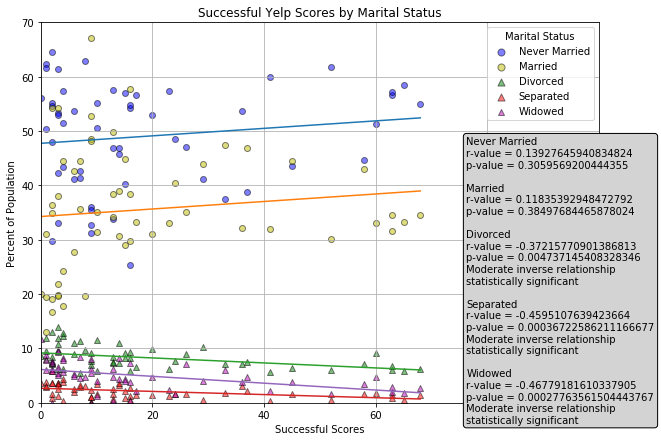

In [173]:
#**********************************************************
# Build the scatter plot for success counts against % household size (data by zipcode)
fig1, ax = plt.subplots()
        
#fig = plt.figure()
ax1 = plt.scatter(df_chi_marital_status_area['success_count'],df_chi_marital_status_area['Never Married_P'], marker="o", facecolors='b', edgecolors="black", linewidths = 1, alpha=0.50)
ax2 = plt.scatter(df_chi_marital_status_area['success_count'],df_chi_marital_status_area['Married_P'], marker="o", facecolors='y', edgecolors="black", linewidths = 1, alpha=0.50)
ax3 = plt.scatter(df_chi_marital_status_area['success_count'],df_chi_marital_status_area['Divorced_P'], marker="^", facecolors='g', edgecolors="black", linewidths = 1, alpha = 0.50)
ax4 = plt.scatter(df_chi_marital_status_area['success_count'],df_chi_marital_status_area['Separated_P'], marker="^", facecolors='r', edgecolors="black", linewidths = 1, alpha = 0.50)
ax5 = plt.scatter(df_chi_marital_status_area['success_count'],df_chi_marital_status_area['Widowed_P'], marker="^", facecolors='m', edgecolors="black", linewidths = 1, alpha = 0.50)

# Get regression stats and add to plot
l1=linregress(df_chi_marital_status_area['success_count'], df_chi_marital_status_area['Never Married_P'])
rvalue1 = l1[2]
pvalue1 = l1[3]  

l2=linregress(df_chi_marital_status_area['success_count'], df_chi_marital_status_area['Married_P'])
rvalue2 = l2[2]
pvalue2 = l2[3]  

l3=linregress(df_chi_marital_status_area['success_count'], df_chi_marital_status_area['Divorced_P'])
rvalue3 = l3[2]
pvalue3 = l3[3]  

l4=linregress(df_chi_marital_status_area['success_count'], df_chi_marital_status_area['Separated_P'])
rvalue4 = l4[2]
pvalue4 = l4[3]  

l5=linregress(df_chi_marital_status_area['success_count'], df_chi_marital_status_area['Widowed_P'])
rvalue5 = l5[2]
pvalue5 = l5[3]  

stat_label = ("Never Married\nr-value = " + str(rvalue1) + "\np-value = " + str(pvalue1) + 
              "\n\nMarried\nr-value = " + str(rvalue2) + "\np-value = " + str(pvalue2) + 
              "\n\nDivorced\nr-value = " + str(rvalue3) + "\np-value = " + str(pvalue3) + "\nModerate inverse relationship\nstatistically significant" +
              "\n\nSeparated\nr-value = " + str(rvalue4) + "\np-value = " + str(pvalue4) + "\nModerate inverse relationship\nstatistically significant" +
              "\n\nWidowed\nr-value = " + str(rvalue5) + "\np-value = " + str(pvalue5) + "\nModerate inverse relationship\nstatistically significant") 

props = dict(boxstyle='round',facecolor = 'lightgrey', alpha=1)
ax.text(1.1, .70, stat_label, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', multialignment = 'left', bbox=props)

# Incorporate the other graph properties
plt.xlabel("Successful Scores")
plt.ylabel("Percent of Population")
plt.ylim(0,70)
plt.xlim(0,100)

# Set legend parameters
plt.grid()
lgnd = plt.legend((ax1, ax2, ax3, ax4, ax5), ('Never Married', 'Married', 'Divorced','Separated', 'Widowed'), title = 'Marital Status')
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]

ax.set_title("Successful Yelp Scores by Marital Status")
fig1.set_size_inches(10,7)

# Add best fit line
plt.plot(np.unique(df_chi_marital_status_area['success_count']), np.poly1d(np.polyfit(df_chi_marital_status_area['success_count'],df_chi_marital_status_area['Never Married_P'],1))(np.unique(df_chi_marital_status_area['success_count'])))
plt.plot(np.unique(df_chi_marital_status_area['success_count']), np.poly1d(np.polyfit(df_chi_marital_status_area['success_count'],df_chi_marital_status_area['Married_P'],1))(np.unique(df_chi_marital_status_area['success_count'])))
plt.plot(np.unique(df_chi_marital_status_area['success_count']), np.poly1d(np.polyfit(df_chi_marital_status_area['success_count'],df_chi_marital_status_area['Divorced_P'],1))(np.unique(df_chi_marital_status_area['success_count'])))
plt.plot(np.unique(df_chi_marital_status_area['success_count']), np.poly1d(np.polyfit(df_chi_marital_status_area['success_count'],df_chi_marital_status_area['Separated_P'],1))(np.unique(df_chi_marital_status_area['success_count'])))
plt.plot(np.unique(df_chi_marital_status_area['success_count']), np.poly1d(np.polyfit(df_chi_marital_status_area['success_count'],df_chi_marital_status_area['Widowed_P'],1))(np.unique(df_chi_marital_status_area['success_count'])))

# Get correlation statistics by marital status
tl = gen_linear_trend( list(df_chi_marital_status_area['success_count']), list(df_chi_marital_status_area['Never Married_P']))
t2 = gen_linear_trend( list(df_chi_marital_status_area['success_count']), list(df_chi_marital_status_area['Married_P']))
t3 = gen_linear_trend( list(df_chi_marital_status_area['success_count']), list(df_chi_marital_status_area['Divorced_P']))
t4 = gen_linear_trend( list(df_chi_marital_status_area['success_count']), list(df_chi_marital_status_area['Separated_P']))
t5 = gen_linear_trend( list(df_chi_marital_status_area['success_count']), list(df_chi_marital_status_area['Widowed_P']))

# Save Figure
plt.savefig("../Chart/Marital_Status_by_Success_Score_scatter.png")

# Show plot
plt.show()

In [43]:
# Run Census Search to retrieve work transportation data on all zip codes (2017 ACS5 Census)

census_data = c.acs5.get(("NAME", "B08006_001E", "B08006_002E", "B08006_003E", "B08006_004E", "B08006_005E", 
                          "B08006_006E","B08006_007E", "B08006_008E", "B08006_009E", "B08006_010E", "B08006_011E", 
                          "B08006_012E","B08006_013E", "B08006_014E", 
                          "B08006_015E", "B08006_016E", "B08006_017E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_work_transport = pd.DataFrame(census_data)

# Column Reordering
df_census_work_transport = df_census_work_transport.rename(columns={"B08006_001E": "Total",
                                                      "B08006_002E": "Car Truck Van",
                                                      "B08006_003E": "Drove Alone",
                                                      "B08006_004E": "Carpool",
                                                      "B08006_005E": "Carpool 2 People",
                                                      "B08006_006E": "Carpool 3 People",
                                                      "B08006_007E": "Carpool 4 or more",
                                                      "B08006_008E": "Public Transportation",
                                                      "B08006_009E": "Bus",
                                                      "B08006_010E": "Streetcar",
                                                      "B08006_011E": "Subway or El",
                                                      "B08006_012E": "Railroad",
                                                      "B08006_013E": "Ferryboat",
                                                      "B08006_014E": "Bicycle",
                                                      "B08006_015E": "Walk",
                                                      "B08006_016E": "Taxi Motorcycle Other",
                                                      "B08006_017E": "Work from Home",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
df_census_work_transport = df_census_work_transport[["Zipcode", "Total", "Car Truck Van", "Drove Alone", "Carpool", "Carpool 2 People",
                       "Carpool 3 People","Carpool 4 or more", "Public Transportation", "Bus", "Streetcar", "Subway or El", 
                        "Railroad", "Ferryboat", "Bicycle", "Walk", "Taxi Motorcycle Other", "Work from Home"]]

# Visualize
print(len(df_census_work_transport))
df_census_work_transport.head()

33120


,Zipcode,Total,Car Truck Van,Drove Alone,Carpool,Carpool 2 People,Carpool 3 People,Carpool 4 or more,Public Transportation,Bus,Streetcar,Subway or El,Railroad,Ferryboat,Bicycle,Walk,Taxi Motorcycle Other,Work from Home
0,84306,190.0,190.0,163.0,27.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,84775,168.0,149.0,124.0,25.0,12.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,2.0
2,84762,158.0,117.0,86.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0
3,84772,108.0,70.0,70.0,0.0,0.0,0.0,0.0,29.0,29.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0
4,84781,72.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0


In [44]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant work transportation data set
# and drop n/a zipcodes with no statistics
df_chi_work_transport = pd.merge(df_census_work_transport, df_chi_zip, on='Zipcode', how = 'right')
df_chi_work_transport = df_chi_work_transport.dropna(how="any")

print(len(df_chi_work_transport))
df_chi_work_transport.head()

56


,Zipcode,Total,Car Truck Van,Drove Alone,Carpool,Carpool 2 People,Carpool 3 People,Carpool 4 or more,Public Transportation,Bus,Streetcar,Subway or El,Railroad,Ferryboat,Bicycle,Walk,Taxi Motorcycle Other,Work from Home
0,60607,17654.0,6279.0,5691.0,588.0,476.0,45.0,67.0,4976.0,2671.0,36.0,1807.0,462.0,0.0,484.0,4491.0,341.0,1083.0
1,60609,23359.0,15890.0,12346.0,3544.0,2564.0,636.0,344.0,5406.0,3619.0,30.0,1599.0,158.0,0.0,172.0,1282.0,121.0,488.0
2,60625,44505.0,23355.0,20235.0,3120.0,2425.0,490.0,205.0,15308.0,4338.0,130.0,9754.0,1086.0,0.0,739.0,2462.0,526.0,2115.0
3,60646,12740.0,10242.0,9326.0,916.0,626.0,198.0,92.0,1561.0,344.0,0.0,596.0,621.0,0.0,36.0,241.0,98.0,562.0
4,60652,18821.0,15477.0,13165.0,2312.0,1949.0,176.0,187.0,2764.0,1259.0,12.0,1182.0,311.0,0.0,0.0,44.0,127.0,409.0


In [45]:
# add city area to work transport information based on zipcode
df_chi_work_transport_area = pd.merge(df_chi_work_transport, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_work_transport_area))
df_chi_work_transport_area.head()

56


,Zipcode,Total,Car Truck Van,Drove Alone,Carpool,Carpool 2 People,Carpool 3 People,Carpool 4 or more,Public Transportation,Bus,Streetcar,Subway or El,Railroad,Ferryboat,Bicycle,Walk,Taxi Motorcycle Other,Work from Home,Area
0,60607,17654.0,6279.0,5691.0,588.0,476.0,45.0,67.0,4976.0,2671.0,36.0,1807.0,462.0,0.0,484.0,4491.0,341.0,1083.0,Central
1,60609,23359.0,15890.0,12346.0,3544.0,2564.0,636.0,344.0,5406.0,3619.0,30.0,1599.0,158.0,0.0,172.0,1282.0,121.0,488.0,South Side
2,60625,44505.0,23355.0,20235.0,3120.0,2425.0,490.0,205.0,15308.0,4338.0,130.0,9754.0,1086.0,0.0,739.0,2462.0,526.0,2115.0,Far North Side
3,60646,12740.0,10242.0,9326.0,916.0,626.0,198.0,92.0,1561.0,344.0,0.0,596.0,621.0,0.0,36.0,241.0,98.0,562.0,Far North Side
4,60652,18821.0,15477.0,13165.0,2312.0,1949.0,176.0,187.0,2764.0,1259.0,12.0,1182.0,311.0,0.0,0.0,44.0,127.0,409.0,Far South West Side


In [46]:
# add success counts to work transport data based on zipcode
df_chi_work_transport_area = pd.merge(df_chi_work_transport_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

# correct count for 60636 that has no yelp ratings
df_chi_work_transport_area.loc[df_chi_work_transport_area['Zipcode']=='60636', ['success_count']] = 0

print(len(df_chi_work_transport_area))
df_chi_work_transport_area.head()

56


,Zipcode,Total,Car Truck Van,Drove Alone,Carpool,Carpool 2 People,Carpool 3 People,Carpool 4 or more,Public Transportation,Bus,Streetcar,Subway or El,Railroad,Ferryboat,Bicycle,Walk,Taxi Motorcycle Other,Work from Home,Area,success_count
0,60607,17654.0,6279.0,5691.0,588.0,476.0,45.0,67.0,4976.0,2671.0,36.0,1807.0,462.0,0.0,484.0,4491.0,341.0,1083.0,Central,52.0
1,60609,23359.0,15890.0,12346.0,3544.0,2564.0,636.0,344.0,5406.0,3619.0,30.0,1599.0,158.0,0.0,172.0,1282.0,121.0,488.0,South Side,2.0
2,60625,44505.0,23355.0,20235.0,3120.0,2425.0,490.0,205.0,15308.0,4338.0,130.0,9754.0,1086.0,0.0,739.0,2462.0,526.0,2115.0,Far North Side,58.0
3,60646,12740.0,10242.0,9326.0,916.0,626.0,198.0,92.0,1561.0,344.0,0.0,596.0,621.0,0.0,36.0,241.0,98.0,562.0,Far North Side,16.0
4,60652,18821.0,15477.0,13165.0,2312.0,1949.0,176.0,187.0,2764.0,1259.0,12.0,1182.0,311.0,0.0,0.0,44.0,127.0,409.0,Far South West Side,6.0


In [47]:
# Save work transportation data as a csv
df_chi_work_transport_area.to_csv("../Data/census_work_transport.csv", encoding="utf-8", index=False)

In [48]:
# Run Census Search to retrieve mortgage data on all zip codes (2017 ACS5 Census)

census_data = c.acs5.get(("NAME", "B25098_002E", "B25098_003E", "B25098_004E", "B25098_005E", 
                          "B25098_006E","B25098_007E", "B25098_008E", "B25098_009E", 
                          "B25098_010E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_mortgage = pd.DataFrame(census_data)

# Column Reordering
df_census_mortgage = df_census_mortgage.rename(columns={"B25098_002E": "Total",
                                                      "B25098_003E": "< 10K",
                                                      "B25098_004E": "< 25K",
                                                      "B25098_005E": "< 35K",
                                                      "B25098_006E": "< 50K",
                                                      "B25098_007E": "< 75K",
                                                      "B25098_008E": "< 100K",
                                                      "B25098_009E": "< 150K",
                                                      "B25098_010E": "> 150K",
                                                "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
df_census_mortgage = df_census_mortgage[["Zipcode", "Total", "< 10K","< 25K", "< 35K", "< 50K", "< 75K",
                       "< 100K", "< 150K", "> 150K"]]

# Visualize
print(len(df_census_mortgage))
df_census_mortgage.head()

33120


,Zipcode,Total,< 10K,< 25K,< 35K,< 50K,< 75K,< 100K,< 150K,> 150K
0,84306,50.0,0.0,0.0,0.0,0.0,13.0,0.0,20.0,17.0
1,84775,78.0,6.0,21.0,3.0,8.0,14.0,10.0,5.0,11.0
2,84762,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
3,84772,23.0,0.0,0.0,6.0,8.0,9.0,0.0,0.0,0.0
4,84781,32.0,0.0,0.0,0.0,10.0,0.0,0.0,15.0,7.0


In [49]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant mortgage data set
# and drop n/a zipcodes with no statistics
df_chi_mortgage = pd.merge(df_census_mortgage, df_chi_zip, on='Zipcode', how = 'right')
df_chi_mortgage = df_chi_mortgage.dropna(how="any")

print(len(df_chi_mortgage))
df_chi_mortgage.head()

56


,Zipcode,Total,< 10K,< 25K,< 35K,< 50K,< 75K,< 100K,< 150K,> 150K
0,60607,4745.0,26.0,52.0,83.0,102.0,406.0,786.0,984.0,2306.0
1,60609,4789.0,163.0,433.0,439.0,660.0,1171.0,721.0,740.0,462.0
2,60625,8341.0,129.0,386.0,346.0,395.0,1139.0,1122.0,2101.0,2723.0
3,60646,4790.0,109.0,70.0,175.0,304.0,360.0,587.0,1124.0,2061.0
4,60652,8524.0,132.0,526.0,574.0,718.0,2037.0,1632.0,1961.0,944.0


In [50]:
# add city area to mortgage information based on zipcode
df_chi_mortgage_area = pd.merge(df_chi_mortgage, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_mortgage_area))
df_chi_mortgage_area.head()

56


,Zipcode,Total,< 10K,< 25K,< 35K,< 50K,< 75K,< 100K,< 150K,> 150K,Area
0,60607,4745.0,26.0,52.0,83.0,102.0,406.0,786.0,984.0,2306.0,Central
1,60609,4789.0,163.0,433.0,439.0,660.0,1171.0,721.0,740.0,462.0,South Side
2,60625,8341.0,129.0,386.0,346.0,395.0,1139.0,1122.0,2101.0,2723.0,Far North Side
3,60646,4790.0,109.0,70.0,175.0,304.0,360.0,587.0,1124.0,2061.0,Far North Side
4,60652,8524.0,132.0,526.0,574.0,718.0,2037.0,1632.0,1961.0,944.0,Far South West Side


In [52]:
# add success counts to under 18 data based on zipcode
df_chi_mortgage_area = pd.merge(df_chi_mortgage_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

# correct count for 60636 that has no yelp ratings
df_chi_mortgage_area.loc[df_chi_mortgage_area['Zipcode']=='60636', ['success_count']] = 0

print(len(df_chi_mortgage_area))
df_chi_mortgage_area.head()

56


,Zipcode,Total,< 10K,< 25K,< 35K,< 50K,< 75K,< 100K,< 150K,> 150K,Area,success_count,success_count_Area
0,60607,4745.0,26.0,52.0,83.0,102.0,406.0,786.0,984.0,2306.0,Central,52.0,52.0
1,60609,4789.0,163.0,433.0,439.0,660.0,1171.0,721.0,740.0,462.0,South Side,2.0,2.0
2,60625,8341.0,129.0,386.0,346.0,395.0,1139.0,1122.0,2101.0,2723.0,Far North Side,58.0,58.0
3,60646,4790.0,109.0,70.0,175.0,304.0,360.0,587.0,1124.0,2061.0,Far North Side,16.0,16.0
4,60652,8524.0,132.0,526.0,574.0,718.0,2037.0,1632.0,1961.0,944.0,Far South West Side,6.0,6.0


In [54]:
# Save children under 18 data as a csv
df_chi_mortgage_area.to_csv("../Data/census_mortgage.csv", encoding="utf-8", index=False)

In [53]:
# Run Census Search to retrieve work children under 18 data on all zip codes (2017 ACS5 Census)

census_data = c.acs5.get(("NAME", "B09001_001E", "B09001_002E", "B09001_003E", "B09001_004E", "B09001_005E", 
                          "B09001_006E","B09001_007E", "B09001_008E", "B09001_009E", 
                          "B09001_010E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_under_18 = pd.DataFrame(census_data)

# Column Reordering
df_census_under_18 = df_census_under_18.rename(columns={"B09001_001E": "Total",
                                                      "B09001_002E": "In Households",
                                                      "B09001_003E": "Under 3",
                                                      "B09001_004E": "3-4",
                                                      "B09001_005E": "5",
                                                      "B09001_006E": "6-8",
                                                      "B09001_007E": "9-11",
                                                      "B09001_008E": "12-14",
                                                      "B09001_009E": "15-17",
                                                      "B09001_010E": "In Group Homes",
                                                "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
df_census_under_18 = df_census_under_18[["Zipcode", "Total", "In Households","Under 3", "3-4", "5", "6-8",
                       "9-11", "12-14", "15-17", "In Group Homes"]]

# Visualize
print(len(df_census_under_18))
df_census_under_18.head()

33120


,Zipcode,Total,In Households,Under 3,3-4,5,6-8,9-11,12-14,15-17,In Group Homes
0,00601,4037.0,4012.0,466.0,471.0,208.0,722.0,520.0,859.0,766.0,25.0
1,00602,7820.0,7815.0,973.0,821.0,416.0,1431.0,1334.0,1252.0,1588.0,5.0
2,00603,10524.0,10321.0,1104.0,1364.0,666.0,1578.0,1841.0,1952.0,1816.0,203.0
3,00606,1326.0,1323.0,149.0,163.0,112.0,165.0,127.0,320.0,287.0,3.0
4,00610,5657.0,5655.0,753.0,503.0,164.0,890.0,955.0,1232.0,1158.0,2.0


In [55]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant children under 18 data set
# and drop n/a zipcodes with no statistics
df_chi_under_18 = pd.merge(df_census_under_18, df_chi_zip, on='Zipcode', how = 'right')
df_chi_under_18 = df_chi_under_18.dropna(how="any")

print(len(df_chi_under_18))
df_chi_under_18.head()

56


,Zipcode,Total,In Households,Under 3,3-4,5,6-8,9-11,12-14,15-17,In Group Homes
0,60601,998.0,988.0,454.0,146.0,71.0,162.0,68.0,0.0,87.0,10.0
1,60602,155.0,149.0,41.0,0.0,0.0,0.0,108.0,0.0,0.0,6.0
2,60603,58.0,58.0,18.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0
3,60604,27.0,27.0,4.0,5.0,0.0,0.0,6.0,0.0,12.0,0.0
4,60605,2444.0,2434.0,798.0,253.0,117.0,426.0,320.0,345.0,175.0,10.0


In [56]:
# add city area to under 18 information based on zipcode
df_chi_under_18_area = pd.merge(df_chi_under_18, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_under_18_area))
df_chi_under_18_area.head()

56


,Zipcode,Total,In Households,Under 3,3-4,5,6-8,9-11,12-14,15-17,In Group Homes,Area
0,60601,998.0,988.0,454.0,146.0,71.0,162.0,68.0,0.0,87.0,10.0,Central
1,60602,155.0,149.0,41.0,0.0,0.0,0.0,108.0,0.0,0.0,6.0,Central
2,60603,58.0,58.0,18.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,Central
3,60604,27.0,27.0,4.0,5.0,0.0,0.0,6.0,0.0,12.0,0.0,Central
4,60605,2444.0,2434.0,798.0,253.0,117.0,426.0,320.0,345.0,175.0,10.0,Central


In [57]:
# add success counts to under 18 data based on zipcode
df_chi_under_18_area = pd.merge(df_chi_under_18_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

# correct count for 60636 that has no yelp ratings
df_chi_under_18_area.loc[df_chi_under_18_area['Zipcode']=='60636', ['success_count']] = 0

print(len(df_chi_under_18_area))
df_chi_under_18_area.head()

56


,Zipcode,Total,In Households,Under 3,3-4,5,6-8,9-11,12-14,15-17,In Group Homes,Area,success_count
0,60601,998.0,988.0,454.0,146.0,71.0,162.0,68.0,0.0,87.0,10.0,Central,4.0
1,60602,155.0,149.0,41.0,0.0,0.0,0.0,108.0,0.0,0.0,6.0,Central,9.0
2,60603,58.0,58.0,18.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,Central,13.0
3,60604,27.0,27.0,4.0,5.0,0.0,0.0,6.0,0.0,12.0,0.0,Central,2.0
4,60605,2444.0,2434.0,798.0,253.0,117.0,426.0,320.0,345.0,175.0,10.0,Central,24.0


In [58]:
# Save children under 18 data as a csv
df_chi_under_18_area.to_csv("../Data/census_under_18.csv", encoding="utf-8", index=False)